# Lab: Predicting google stock market using LSTM

**Recurrent Neural Networks** are the first of its kind State of the Art algorithms that can remember previous inputs in memory, when a huge set of sequential data is given to it.  LSTM works on the principle of saving the output of a layer and feeding this back to the input in order to predict the output of the layer.  

Good prediction systems for the stock market, in this case predicting google stock, would help traders, investors, and analysts by providing information of the future direction of the stock market.    

Here we will be using an LSTM to predict google stock.

This notebook is pretty much the same as [rnn-stock-price-prediction](rnn-stock-price-prediction.ipynb) except for the LSTM

**WARNING: For training purpose only, not investment advice :-)**

In [2]:
## Determine if we are running on google colab ///// Done

try:
    import google.colab
    RUNNING_IN_COLAB = True
except:
    RUNNING_IN_COLAB = False

print ("Running in Google COLAB : ", RUNNING_IN_COLAB)

Running in Google COLAB :  False


**TensorFlow** is a free and open-source software library for dataflow and differentiable programming across a range of tasks.  
It is a symbolic math library, and is also used for machine learning applications such as neural networks.  

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
print ("tf version: ", tf.__version__)
print ("keras version: ", keras.__version__)

tf version:  2.3.0
keras version:  2.4.0


## TF-GPU Debug
The following block tests if TF is running on GPU.

In [4]:
print (tf.config.experimental.list_physical_devices())

## This block is to tweak TF running on GPU
## You may comment this out, if you are not using GPU

## ---- start Memory setting ----
## Ask TF not to allocate all GPU memory at once.. allocate as needed
## Without this the execution will fail with "failed to initialize algorithm" error

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
## ---- end Memory setting ----


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5



## Step 1: Load data
**Google stock market** dataset is a common educational csv dataset containing like 1,278 rows.  
This is historical stock data collected from the google stock price.  

In [5]:
import pandas as pd
import os

data_train = 'https://elephantscale-public.s3.amazonaws.com/data/stocks/google-stock-price-train.csv'
data_test = 'https://elephantscale-public.s3.amazonaws.com/data/stocks/google-stock-price-test.csv'

data_train_local = keras.utils.get_file(fname=os.path.basename(data_train),
                                           origin=data_train, extract=True)
print ('data_train_local: ', data_train_local)

data_test_local = keras.utils.get_file(fname=os.path.basename(data_test),
                                           origin=data_test, extract=True)
print ('data_test_local: ', data_test_local)

data_train_local:  /home/sujee/.keras/datasets/google-stock-price-train.csv
data_test_local:  /home/sujee/.keras/datasets/google-stock-price-test.csv


## Step 2: Explore data
We will be given stock google stock price data with **Date**, **Open** price, **High** Price, **Low** Price, **Close** price, and **Volume** of shares that changed hands.   

In [6]:
dataset_train = pd.read_csv(data_train_local,index_col="Date",parse_dates=True, thousands=',')
print (dataset_train)
dataset_train

              Open    High     Low   Close    Volume
Date                                                
2012-01-03  325.25  332.83  324.97  663.59   7380500
2012-01-04  331.27  333.87  329.08  666.45   5749400
2012-01-05  329.83  330.75  326.89  657.21   6590300
2012-01-06  328.34  328.77  323.68  648.24   5405900
2012-01-09  322.04  322.29  309.46  620.76  11688800
...            ...     ...     ...     ...       ...
2016-12-23  790.90  792.74  787.28  789.91    623400
2016-12-27  790.68  797.86  787.66  791.55    789100
2016-12-28  793.70  794.23  783.20  785.05   1153800
2016-12-29  783.33  785.93  778.92  782.79    744300
2016-12-30  782.75  782.78  770.41  771.82   1770000

[1258 rows x 5 columns]


,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,7380500
2012-01-04,331.27,333.87,329.08,666.45,5749400
2012-01-05,329.83,330.75,326.89,657.21,6590300
2012-01-06,328.34,328.77,323.68,648.24,5405900
2012-01-09,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...
2016-12-23,790.90,792.74,787.28,789.91,623400
2016-12-27,790.68,797.86,787.66,791.55,789100
2016-12-28,793.70,794.23,783.20,785.05,1153800


### Rolling Mean on Time series
A rolling analysis of a time series model is often used to assess the model’s stability over time. When analyzing financial time series data using a statistical model, a key assumption is that the parameters of the model are constant over time

<AxesSubplot:xlabel='Date'>

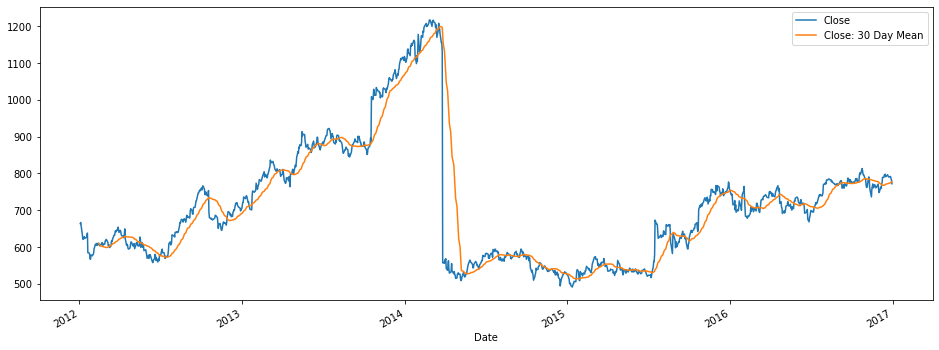

In [7]:
dataset_train['Close: 30 Day Mean'] = dataset_train['Close'].rolling(window=30).mean()
dataset_train[['Close','Close: 30 Day Mean']].plot(figsize=(16,6))

## Stocks opening representation over the period of time

<AxesSubplot:xlabel='Date'>

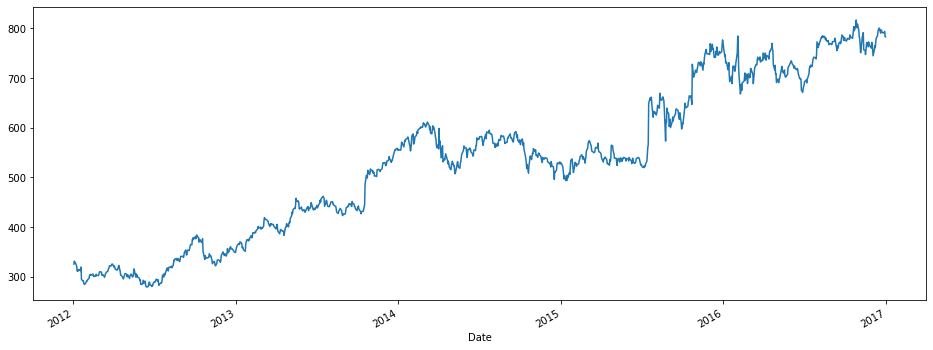

In [8]:
dataset_train['Open'].plot(figsize=(16,6))

## Step 3: Preprocessing

Here are the steps for our preprocessing 
 - **Data discretization:** Part of data reduction but with particular importance, especially for numerical data.  
 - **Data transformation:** Normalization.  
 - **Data Cleaning:** Fill in missing values.  
 - **Data integration:** Integration of data files. After the dataset is transformed into a clean dataset, the dataset is divided into training and testing sets so as to evaluate.


In [9]:
#Data cleaning

from sklearn.preprocessing import MinMaxScaler

dataset_train.isna().any()# Feature Scaling Normalization
#Transform features by scaling each feature between 0 - 1
sc = MinMaxScaler(feature_range = (0, 1)) 

training_set_scaled = sc.fit_transform(dataset_train)  #Feature extractor then takes data and returns some transformed data back

training_set_scaled

array([[0.08581368, 0.09640129, 0.09044931, 0.23757287, 0.29525831,
               nan],
       [0.09701243, 0.09834351, 0.09823458, 0.24151427, 0.22993592,
               nan],
       [0.09433366, 0.09251685, 0.09408623, 0.22878051, 0.26361233,
               nan],
       ...,
       [0.95725128, 0.95807422, 0.95844067, 0.40495845, 0.04589107,
        0.38306889],
       [0.93796041, 0.94257381, 0.95033338, 0.40184391, 0.02949139,
        0.38425019],
       [0.93688146, 0.93669113, 0.93421352, 0.38672602, 0.07056868,
        0.38460701]])

## Step 4: Shape data
Shaping the data so we can have it suitable to work with.  

In [10]:
import numpy as np

## Data structure with 60 timesteps and 1 output
time_steps = 60

x_train = []
y_train = []
for i in range(time_steps, len(dataset_train)):
    x_train.append(training_set_scaled[i-time_steps:i, 0]) 
    y_train.append(training_set_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [11]:
for i in range(3):
  print("Independent feature values are: ")
  print( x_train[i], end='')
  print("Dependent feature value is :" , y_train[i])
  print ('------')

Independent feature values are: 
[[0.08581368]
 [0.09701243]
 [0.09433366]
 [0.09156187]
 [0.07984225]
 [0.0643277 ]
 [0.0585423 ]
 [0.06568569]
 [0.06109085]
 [0.06639259]
 [0.0614257 ]
 [0.07474514]
 [0.02797827]
 [0.02379269]
 [0.02409033]
 [0.0159238 ]
 [0.01078949]
 [0.00967334]
 [0.01642607]
 [0.02100231]
 [0.02280676]
 [0.02273235]
 [0.02810849]
 [0.03212665]
 [0.0433812 ]
 [0.04475779]
 [0.04790163]
 [0.0440695 ]
 [0.04648783]
 [0.04745517]
 [0.04873875]
 [0.03936305]
 [0.04137213]
 [0.04034898]
 [0.04784582]
 [0.04325099]
 [0.04356723]
 [0.04286033]
 [0.04602277]
 [0.05398467]
 [0.05738894]
 [0.05714711]
 [0.05569611]
 [0.04421832]
 [0.04514845]
 [0.04605997]
 [0.04412531]
 [0.03675869]
 [0.04486941]
 [0.05065481]
 [0.05214302]
 [0.05612397]
 [0.05818885]
 [0.06540665]
 [0.06882953]
 [0.07243843]
 [0.07993526]
 [0.07846566]
 [0.08034452]
 [0.08497656]]Dependent feature value is : 0.08627874097775134
------
Independent feature values are: 
[[0.09701243]
 [0.09433366]
 [0.091561

## Step 5: Build model
Build a model or set of models to solve the problem, test how well they perform and iterate until you have a model that gives satisfactory results.  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


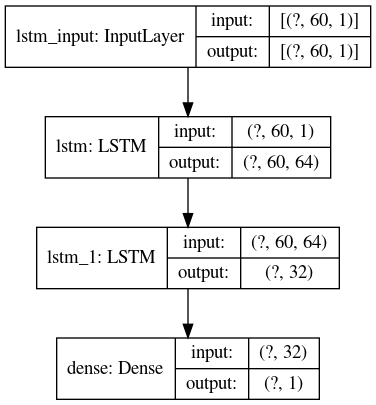

In [12]:
# Initialising the Network
model = tf.keras.Sequential()

# Adding the first LSTM Layer
#The model needs to know what input shape it should expect. 
#For this reason, the first layer in a Sequential model needs to receive information about its input shape.
#Only the first, because following layers can do automatic shape inference. 

# if we are feeding to another LSTM layer, we need to have `return_sequences=True`
model.add(tf.keras.layers.LSTM(units = 64, return_sequences = True, 
                                    input_shape = (x_train.shape[1], 1)))

# Adding a 2nd LSTM layefr
model.add(tf.keras.layers.LSTM(units = 32))

# Adding the output layer
# only need 1 neuron for regression
model.add(tf.keras.layers.Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mse', metrics=['mse'])

model.summary()
# Plotting the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

## Step 6 : Add Tensorboard

**TensorBoard** provides the visualization and tooling needed for machine learning experimentation.  

In [13]:
## This is fairly boiler plate code

import datetime
import os
import shutil

app_name = 'lstm-stocks'

# timestamp  = datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

tb_top_level_dir= '/tmp/tensorboard-logs'

tb_app_dir = os.path.join (tb_top_level_dir, app_name)

tb_logs_dir = os.path.join (tb_app_dir, datetime.datetime.now().strftime("%H-%M-%S"))


print ("Saving TB logs to : " , tb_logs_dir)

#clear out old logs
shutil.rmtree ( tb_app_dir, ignore_errors=True )

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_logs_dir, write_graph=True, 
                                                      write_images=True, histogram_freq=1)

## This will embed Tensorboard right here in jupyter!
%load_ext tensorboard
%tensorboard --logdir $tb_logs_dir

Saving TB logs to :  /tmp/tensorboard-logs/lstm-stocks/20-49-34


## Step 7: Train 

 - Optimizer **Adam**, which is an adaptive learning rate optimization algorithm that's been designed specifically for training deep neural networks.  
 - **Mean Squared Error Loss**, it is the preferred loss function under the inference framework of maximum likelihood if the distribution of the target variable is Gaussian. It is the loss function to be evaluated first and only changed if you have a good reason.  

In [14]:
%%time

print ("training starting ...")

# Fitting the model to the Training set
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, callbacks=[tensorboard_callback])

print ("training done.")

training starting ...
Epoch 1/10
 1/38 [..............................] - ETA: 0s - loss: 0.1964 - mse: 0.1964WARNING:tensorflow:From /home/sujee/anaconda3/envs/tf-2.3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
38/38 [==============================] - 0s 7ms/step - loss: 0.0208 - mse: 0.0208
Epoch 2/10
38/38 [==============================] - 0s 6ms/step - loss: 0.0016 - mse: 0.0016
Epoch 3/10
38/38 [==============================] - 0s 6ms/step - loss: 0.0014 - mse: 0.0014 
Epoch 4/10
38/38 [==============================] - 0s 5ms/step - loss: 0.0012 - mse: 0.0012
Epoch 5/10
38/38 [==============================] - 0s 5ms/step - loss: 0.0012 - mse: 0.0012 
Epoch 6/10
38/38 [==============================] - 0s 9ms/step - loss: 0.0012 - mse: 0.0012
Epoch 7/10
38/38 [======================

## Step 8: Training History

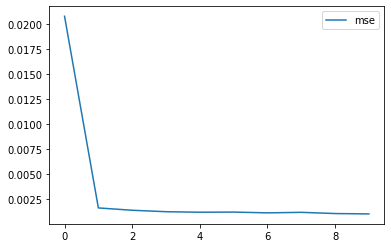

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['mse'], label='mse')
plt.legend()
plt.show()

## Step 9: Predict
We will now test the model with our Google_Stock_Price_Test.csv.  


In [16]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv(data_test_local,index_col="Date",parse_dates=True, thousands = ',')
real_stock_price = dataset_test.iloc[:, 1:2].values
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)

# Getting the last 80 values
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_steps:].values

inputs = inputs.reshape(-1,1)
inputs = sc.fit_transform(inputs)
x_test = []
# 
for i in range(time_steps, time_steps+20):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_stock_price = model.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

predicted_stock_price

array([[792.64026],
       [791.79767],
       [791.0313 ],
       [790.1808 ],
       [789.76855],
       [790.1852 ],
       [791.22156],
       [792.54877],
       [794.1715 ],
       [795.94714],
       [797.7352 ],
       [799.3884 ],
       [800.83673],
       [802.15857],
       [803.32544],
       [805.1003 ],
       [807.50684],
       [810.66266],
       [814.0043 ],
       [816.28186]], dtype=float32)

## Step 10: Visualize result
### 10.1: Compare real stock price with prediction

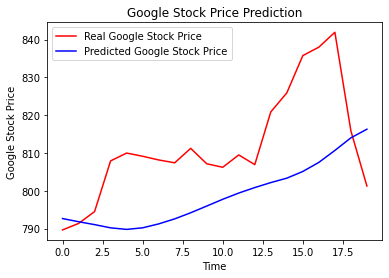

In [17]:
import matplotlib.pyplot as plt
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

## Step 11: Class Discussion
Discuss your findings

### Source:
https://blog.usejournal.com/stock-market-prediction-by-recurrent-neural-network-on-lstm-model-56de700bff68

## Cleanup 
Before running the next exercise, run the following cell to terminate processes and free up resources

In [18]:
## Kill any child processes (like tensorboard)

import psutil
import os, signal

current_process = psutil.Process()
children = current_process.children(recursive=True)
for child in children:
    print('Killing Child pid  {}'.format(child.pid))
    os.kill(child.pid, signal.SIGKILL)
    
## This will kill actual kernel itself
# os.kill(os.getpid(), signal.SIGKILL)

Killing Child pid  5093
